In [3]:
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW,  get_linear_schedule_with_warmup, pipeline 
from sklearn.metrics import f1_score, precision_score, multilabel_confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import transformers
import evaluate 
import missingno as ms


# Check torch and CUDA versions
print(torch.__version__)  # Should display the version of PyTorch with CUDA support
print(torch.version.cuda)  # Should display the CUDA version
print(torch.backends.cudnn.version())  # Should display the cuDNN version
print(torch.cuda.is_available())  # Should return True if CUDA is available

c:\Users\hp\Desktop\context_detector\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.1+cu118
11.8
8700
True


First, let's set the environment variables:
1. Subsample: this is an optional feature to work on a portion of the dataset so we can speed up the computation time. 
2. Seed: to make the results replicable
3. LR (Learning Rate): the higher, the faster the model converges to an optimal solution, but there's a risk of getting stuck in a local minima and not finding the global minimum.
4. Batch size: 

Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_14284\2421997005.py:21: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


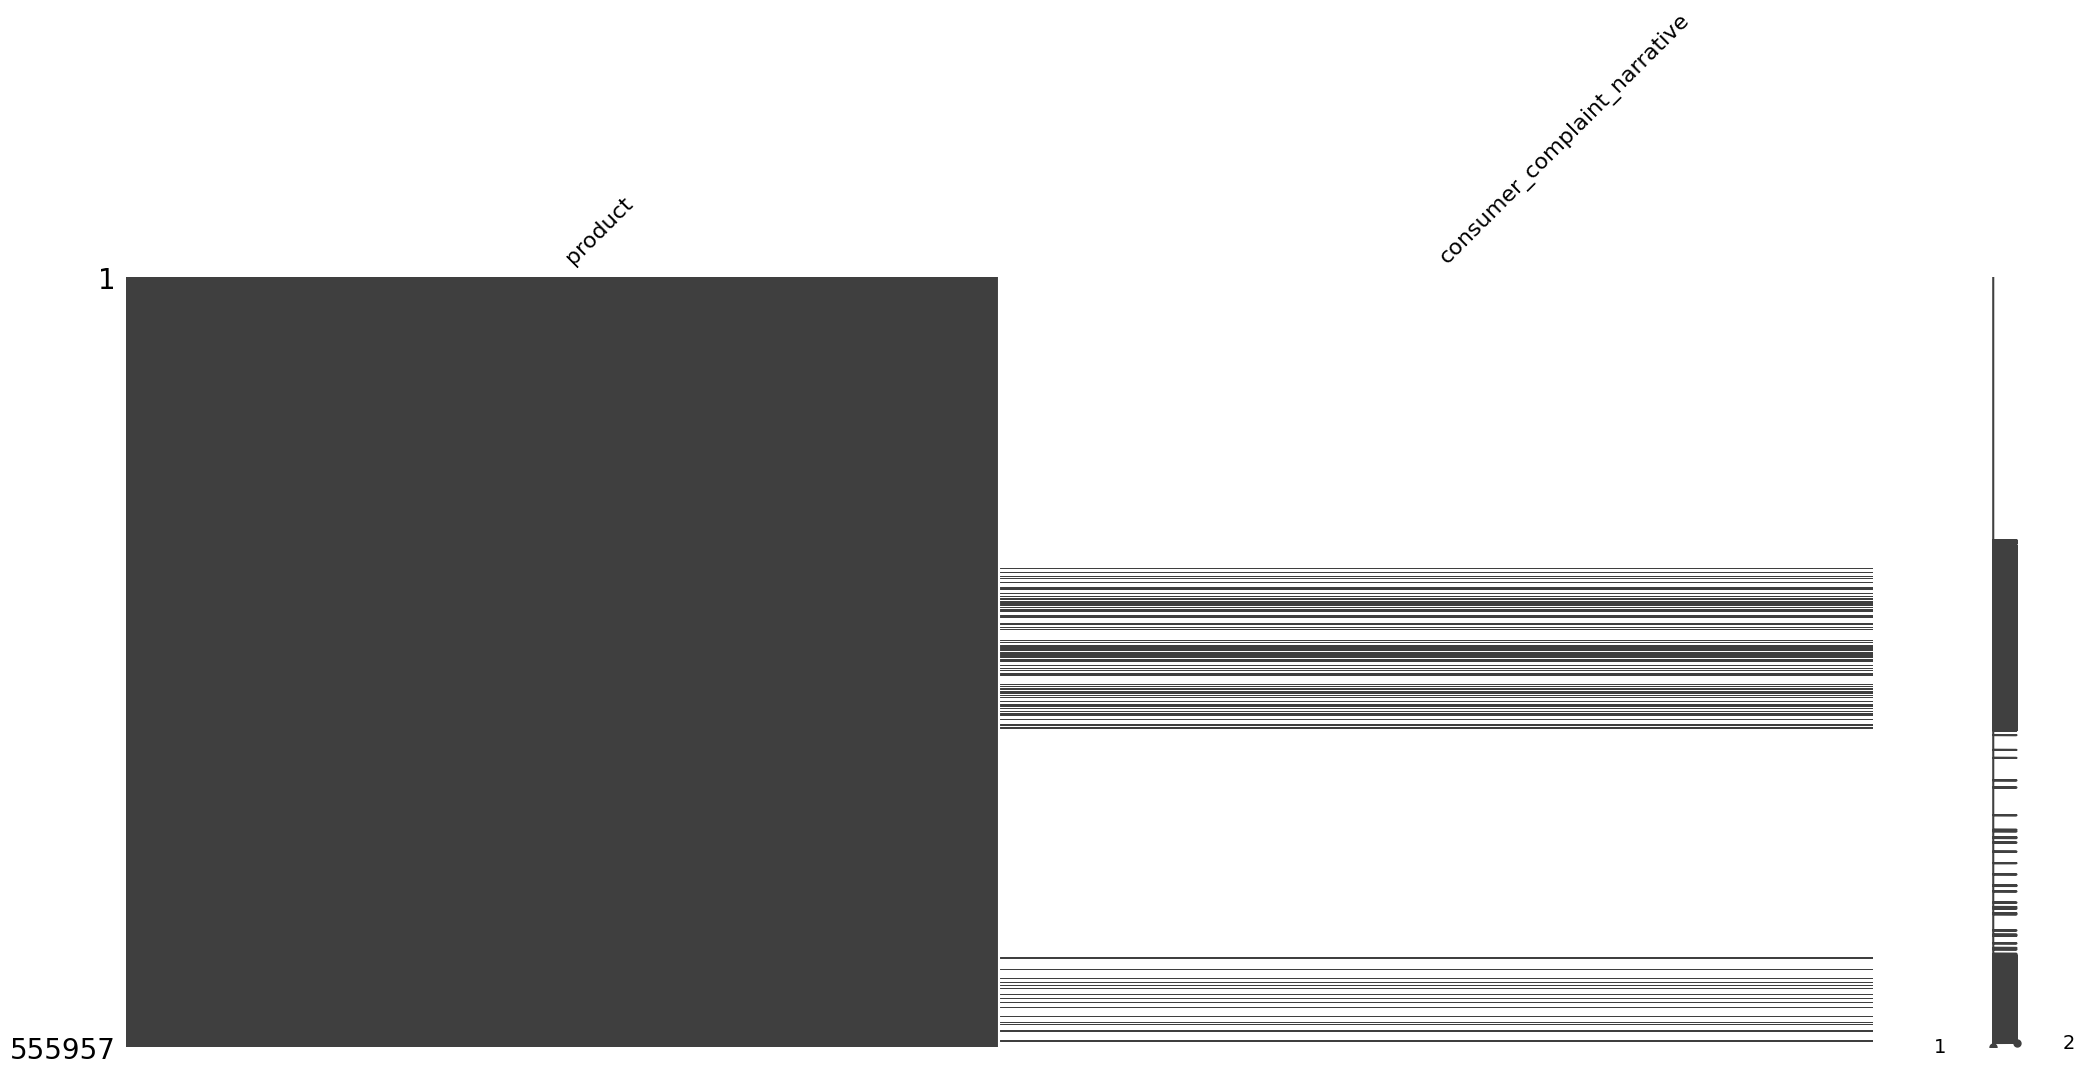

In [4]:
# Set global variables and tokenizer parameters
SUBSAMPLE = False
SEED = 42
LR = 2e-5
BATCH_SIZE = 10
EPOCHS = 5
MAX_LEN = 256

# Define parameters for the tokenizer 
tokenizer_params = {
    'add_special_tokens': True,     # adds [CLS] and [SEP] tags
    'return_attention_mask': True,  # useful for distinguishing between actual data and padding
    'pad_to_max_length': True,      # to ensure all sequences have the same length
    'truncation': True,
    'max_length': MAX_LEN,          # set the maximum length for sequences
    'return_tensors': 'pt'          # use 'pt' when using PyTorch, 'tf' for TensorFlow
}

# Load data 
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']].reset_index(drop=True)

# Plot missing values 
ms.matrix(data)

# Drop rows with null values
data = data.dropna()

# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.02, random_state=SEED)

# Remove the categories with not enough samples
categories_to_drop = ['Consumer Loan', 
                    'Bank account or service',
                    'Student loan', 
                    'Prepaid card',
                    'Payday loan', 
                    'Money transfers', 
                    'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]

### Preprocessing

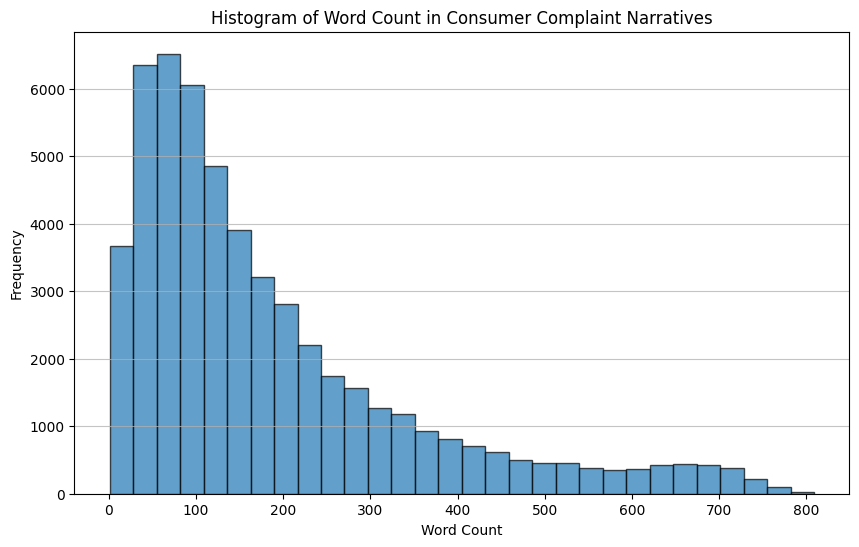

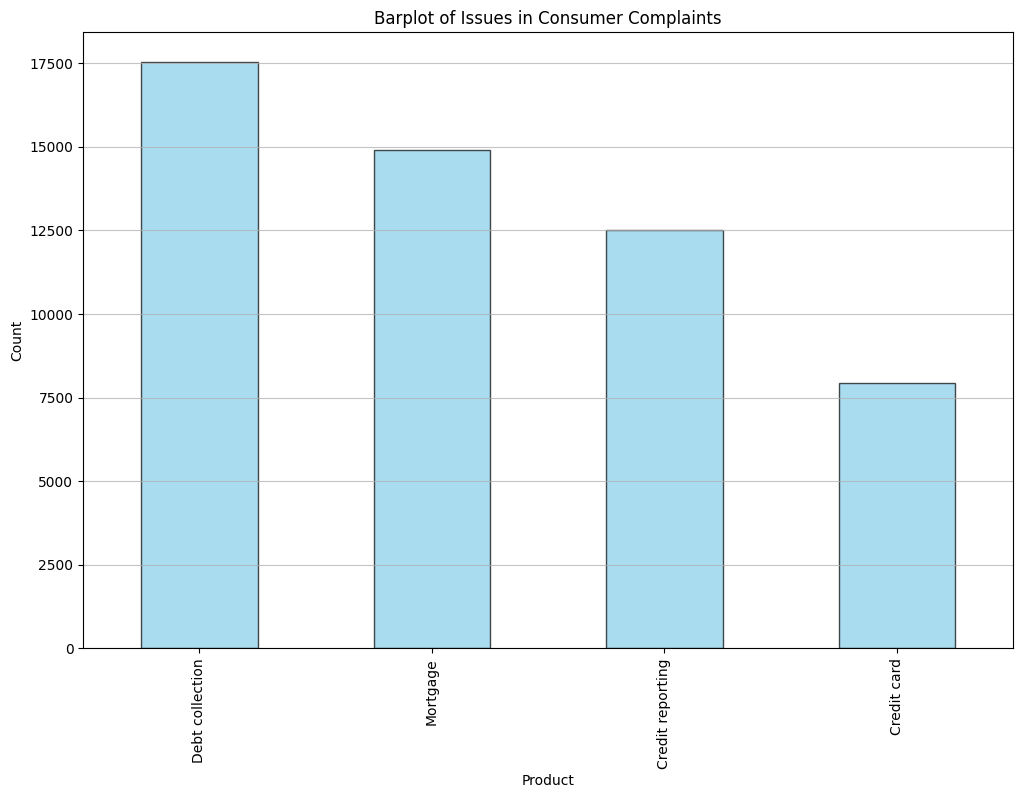

In [72]:
# Category visualization
# Create a histogram with the word count for the column 'consumer_complaint_narrative'
data['narrative_word_count'] = data['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(data['narrative_word_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Word Count in Consumer Complaint Narratives')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Create a barplot counting each unique value in the column 'issue'
issue_counts = data['product'].value_counts()
plt.figure(figsize=(12, 8))
issue_counts.plot(kind='bar', color='skyblue', edgecolor='k', alpha=0.7)
plt.title('Barplot of Issues in Consumer Complaints')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.75)
plt.show()




In [5]:
# Text cleanup
def clean_text(text): 
    text = text.replace('\n', '').strip()
    # text = text.replace('XXXX', '')
    # text = re.sub(r'[^A-Za-z\s]', '', text)   # remove special characters
    return text
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(clean_text)

# Encoding labels 
labs_ = data['product'].unique()    # Creates array: ['Debt collection', 'Mortgage', 'Credit card', 'Credit reporting']
lab_dict = dict()    
id_dict = dict()                 
for idx, lab in enumerate(labs_): 
    lab_dict[lab] = idx             # This'll create {'Debt collection': 0, 'Mortgage': 1, 'Credit card': 2,...}
    id_dict[idx] = lab
data['label'] = data['product'].replace(lab_dict)
data.head()

,product,consumer_complaint_narrative,label
516673,Debt collection,I have been battling with portfolio recovery a...,0
516092,Mortgage,In the fall of XXXX I applied for a mortgage m...,1
236006,Credit card,i tried to call this number and i can not call...,2
316478,Credit reporting,Trans union is showing a old debt against me o...,3
241895,Credit reporting,The letter was mailed out on XXXX XXXX. The Ex...,3


Tokenize and extract input IDs and attention masks. Do we need to use them as inputs for the model. 
- Input ID: array containing the IDs for each token 
- Attention mask: so the model can distinguish between padding and actual data (1 for data, 0 for padding)

In [74]:
# # Create train-test split 
# X_train, X_val, y_train, y_val = train_test_split(
#     data['consumer_complaint_narrative'], 
#     data['label'], 
#     train_size=0.8,
#     test_size=0.2, 
#     random_state=SEED,
#     stratify=data['label']       # use stratification even if it doesn't seem necessary
#     )
# print(X_train)
# # Tokenize text
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
#                                                 do_lower_case=True)

# # Apply tokenizer to train and validation datasets separately
# encoded_X_train = tokenizer.batch_encode_plus(X_train, **tokenizer_params)
# encoded_X_val = tokenizer.batch_encode_plus(X_val, **tokenizer_params)

# # Gather the inputs for the model
# # Extract input IDs and attention mask (they were generated as tensors)
# input_ids_train = encoded_X_train['input_ids']
# attention_mask_train = encoded_X_train['attention_mask']
# train_labs = torch.tensor(y_train.values)

# input_ids_val = encoded_X_val['input_ids']
# attention_mask_val = encoded_X_val['attention_mask']
# val_labs = torch.tensor(y_val.values)

# # Convert to pandas DataFrame for easy manipulation. Make sure the names of the columns are input_ids, attention_mask
# # and labels
# train_df = pd.DataFrame({
#     'input_ids': input_ids_train.tolist(),
#     'attention_mask': attention_mask_train.tolist(),
#     'labels': train_labs.tolist()
# })

# val_df = pd.DataFrame({
#     'input_ids': input_ids_val.tolist(),
#     'attention_mask': attention_mask_val.tolist(),
#     'labels': val_labs.tolist()
# })

# # Convert DataFrame to Dataset
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)

# # Create DatasetDict
# dataset_dict = DatasetDict({
#     'train': train_dataset,
#     'validation': val_dataset
# })
# print(dataset_dict)

# # Transform into tensors to be manipulated by PyTorch 
# dataset_dict.set_format("torch")

# # Transform into dataloaders for batch training
# train_loader = DataLoader(
#     dataset_dict["train"], shuffle=True, batch_size=BATCH_SIZE
# )
# eval_loader = DataLoader(
#     dataset_dict["validation"], batch_size=BATCH_SIZE
# )

# # Examine first batch 
# first_batch = next(iter(train_loader))
# for key, value in first_batch.items():
#     print(f"{key}: {value[:5]}") 

In [6]:
# Create train-test split 
X_train, X_val, y_train, y_val = train_test_split(
    data['consumer_complaint_narrative'], 
    data['label'], 
    train_size=0.8,
    test_size=0.2, 
    random_state=SEED,
    stratify=data['label']       # use stratification even if it doesn't seem necessary
    )

# Create dataframes
X_train_df = pd.DataFrame(X_train)
X_train_df['labels'] = y_train
X_val_df = pd.DataFrame(X_val)
X_val_df['labels'] = y_val

# Create datasets
train_dts = Dataset.from_pandas(X_train_df)
eval_dts = Dataset.from_pandas(X_val_df)

# Create dataset dict 
dataset_dict = DatasetDict({"train": train_dts, 
                            "validation": eval_dts})

# Tokenize text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                                do_lower_case=True)
def tokenise(batch): 
    return tokenizer(batch["consumer_complaint_narrative"], **tokenizer_params)
dataset_dict = dataset_dict.map(tokenise, batched=True, batch_size=BATCH_SIZE)

# Remove and re-order columns 
dataset_dict = dataset_dict.select_columns(['input_ids', 'attention_mask', 'labels'])

# Transform into tensors to be manipulated by PyTorch 
dataset_dict.set_format("torch")
print(dataset_dict)

# Transform into dataloaders for batch training
train_loader = DataLoader(
    dataset_dict["train"], shuffle=True, batch_size=BATCH_SIZE
)
eval_loader = DataLoader(
    dataset_dict["validation"], batch_size=BATCH_SIZE
)

# Examine first batch 
print("Print first batch of the loader")
first_batch = next(iter(train_loader))
for key, value in first_batch.items():
    print(f"{key}: {value[:5]}") 


Map:   0%|          | 0/831 [00:00<?, ? examples/s]c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Map: 100%|██████████| 208/208 [00:01<00:00, 203.83 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 831
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 208
    })
})
Print first batch of the loader
input_ids: tensor([[ 101, 2023, 2003,  ...,    0,    0,    0],
        [ 101, 2045, 2003,  ...,    0,    0,    0],
        [ 101, 1045, 2363,  ...,    0,    0,    0],
        [ 101, 6887, 2232,  ..., 2515, 2025,  102],
        [ 101, 1999, 2249,  ...,    0,    0,    0]])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
labels: tensor([0, 3, 1, 1, 3])


### Benchmarks
Now we create two benchmark models to see if our model can outperform them.
The first benchmark is going to be a simple randomized model. This model is going to make predictions randomly.
The second benchmark model is going to be a zero-shot model from the transformers library.
We want to create a model that obtains better performance than these two.

First, let's define the accuracy functions. We will be using precision (as accuracy is not ideal for imbalanced data), F1 score and a confussion matrix. 

In [76]:
random.seed(SEED)

# define true values and randomized values
y_true = y_val.sample(1000).values
y_pred = [random.randint(0, 3) for _ in range(len(y_true))]

# Calculate precision
print('Precision score: ', precision_score(y_true, y_pred, average='weighted'))
print('F1 score: ', f1_score(y_true, y_pred, average='weighted'))

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)
print(cm)

# Where 1 means perfect prediction, 0 random predictions, -1 inverse predictions
print(matthews_corrcoef(y_true, y_pred))

del cm
del y_pred
del y_true

Precision score:  0.2564053086419753
F1 score:  0.24162683999527154
[[[489 166]
  [268  77]]

 [[542 177]
  [215  66]]

 [[642 210]
  [108  40]]

 [[565 209]
  [171  55]]]
-0.014584110382625288


As expected, the MCC is close to 0 (= random predictions), and the F1 score is ~0.25, so the model is not really reliable. 

In [77]:
n_sample = 20
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli')

subsample = data.sample(n=n_sample)
texts_ = subsample['consumer_complaint_narrative']
y_true =  subsample['label']

candidate_labels = [n for n in range(0, 3)]

y_pred = []
for text in texts_: 
    res = classifier(text, candidate_labels=candidate_labels)
    y_pred.append(res['labels'][0])

# Calculate precision
print('Precision score: ', precision_score(y_true, y_pred, average='weighted'))
print('F1 score: ', f1_score(y_true, y_pred, average='weighted'))

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)
print(cm)

# Where 1 means perfect prediction, 0 random predictions, -1 inverse predictions
print(matthews_corrcoef(y_true, y_pred))

del cm
del subsample
del y_pred
del y_true

Precision score:  0.15555555555555556
F1 score:  0.21538461538461542
[[[12  1]
  [ 7  0]]

 [[ 1 11]
  [ 1  7]]

 [[17  1]
  [ 2  0]]

 [[17  0]
  [ 3  0]]]
-0.09129609692138818


c:\Users\hp\Desktop\context_detector\env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The zero-shot model performed slightly better.

Load pre-trained model + optimizer + scheduler 

The scheduler adjusts the learning rate during training. Determines the step size at each iteration to escape local minima. 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Starting model training...



Epoch 1/5:   0%|          | 0/70 [00:23<?, ?it/s]
c:\Users\hp\Desktop\context_detector\env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/5
Training loss: 1.3602
Validation loss: 1.2373
F1 Score: 0.4093
Precision: 0.3996



Epoch 2/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 2/5
Training loss: 0.8845
Validation loss: 0.5638
F1 Score: 0.8311
Precision: 0.8376



Epoch 3/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 3/5
Training loss: 0.4213
Validation loss: 0.4274
F1 Score: 0.8509
Precision: 0.8523



Epoch 4/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 4/5
Training loss: 0.2505
Validation loss: 0.3924
F1 Score: 0.8616
Precision: 0.8645



Epoch 5/5:   0%|          | 0/70 [00:22<?, ?it/s]


Epoch: 5/5
Training loss: 0.1782
Validation loss: 0.3811
F1 Score: 0.8713
Precision: 0.8743



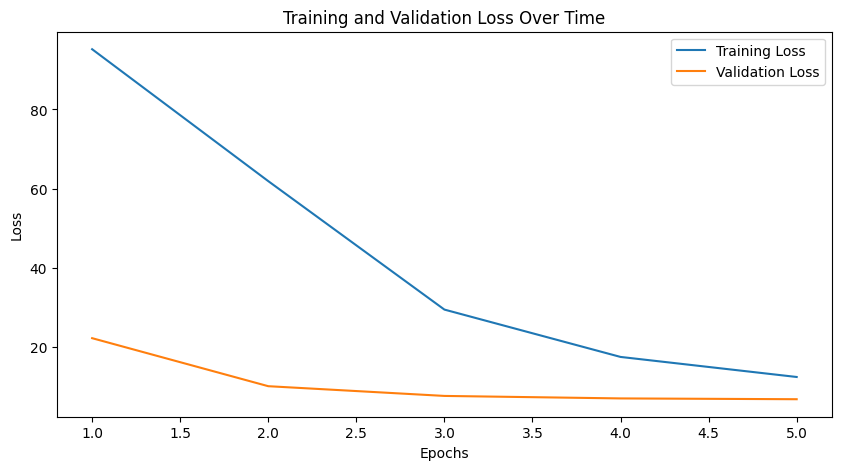

In [10]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                            num_labels=len(lab_dict), 
                                                            output_attentions=False)

# Move model to device
model.to(device)

# Load optimizer 
optimizer = AdamW(model.parameters(),
                lr=LR,   
                eps=1e-8)       # add constant to prevent division by zero 

# Define scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=100, 
                                            num_training_steps=len(train_loader) * EPOCHS)

# Accuracy metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Training loop 
print("Starting model training...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        for batch in train_loader:
            batch = {k: b.to(device) for k, b in batch.items()}             # move the batch to the device 
            outputs = model(**batch)  

            # Compute loss
            loss = outputs.loss
            loss.backward()
            train_loss += loss.item()
            
            optimizer.step()                                                # update parameters
            scheduler.step()                                                # update learning rate 
            optimizer.zero_grad()                                           # clear previous gradients
            # progress_bar.update(1)
        
    avg_train_loss = train_loss / len(train_loader)
    torch.save(model.state_dict(), f'models/BERT_epoch_{epoch+1}.model')

    # Evaluation loop 
    model.eval()
    val_loss = 0 
    for batch in eval_loader: 
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Evaluate predictions
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        
    avg_val_loss = val_loss / len(eval_loader)
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')

    training_losses.append(train_loss)
    validation_losses.append(val_loss)


    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Training loss: {avg_train_loss:.4f}")
    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"F1 Score: {f1['f1']:.4f}")
    print(f"Precision: {precision['precision']:.4f}")
    print("================================\n")

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
print(model)

# Custom model
Let's add some modifications to the model. 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting model training...



Epoch 1/5:   0%|          | 0/70 [00:22<?, ?it/s]


Epoch: 1/5
Training loss: 1.1491
Validation loss: 0.6727
F1 Score: 0.7719
Precision: 0.7926



Epoch 2/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 2/5
Training loss: 0.5231
Validation loss: 0.4511
F1 Score: 0.8277
Precision: 0.8319



Epoch 3/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 3/5
Training loss: 0.3271
Validation loss: 0.4007
F1 Score: 0.8516
Precision: 0.8524



Epoch 4/5:   0%|          | 0/70 [00:23<?, ?it/s]


Epoch: 4/5
Training loss: 0.2016
Validation loss: 0.4049
F1 Score: 0.8563
Precision: 0.8574



Epoch 5/5:   0%|          | 0/70 [00:22<?, ?it/s]


Epoch: 5/5
Training loss: 0.1539
Validation loss: 0.4010
F1 Score: 0.8516
Precision: 0.8525



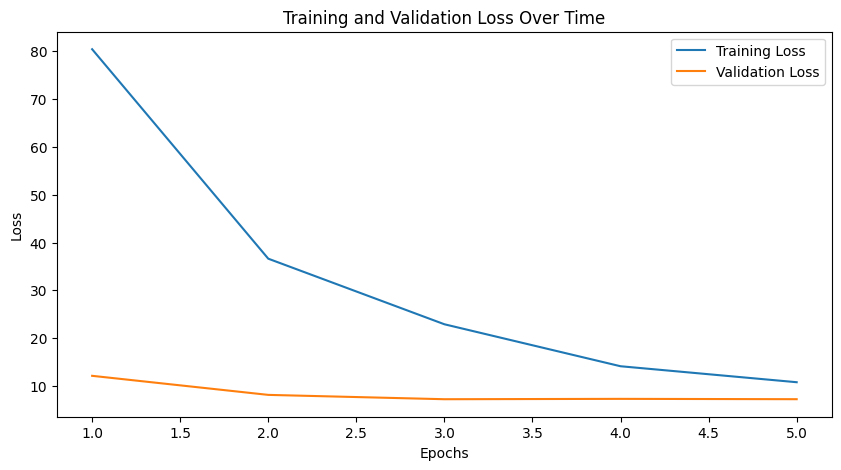

In [9]:
#TODO: Change previous Code to the new dataset class from https://medium.com/@parkermo_86729/using-pytorch-hugging-face-and-a-pretrained-bert-model-to-create-news-source-classifier-a-46dddbd4d919
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define custom model 
class TextClassifier(torch.nn.Module): 
    def __init__(self): 
        super(TextClassifier, self).__init__()
        self.distilbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=len(lab_dict))
        self.dropout = torch.nn.Dropout(0.3)
        self.output = torch.nn.Linear(768, len(lab_dict))

    # Define forward function 
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.distilbert(input_ids, attention_mask=attention_mask)
        output = self.dropout(output[0][:, 0, :])  # Use the [CLS] token representation
        logits = self.output(output)
        return logits

# Accuracy metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")

# Declare model and move to device
model = TextClassifier()
model.to(device)

# Load optimizer 
optimizer = AdamW(model.parameters(),
                lr=LR,   
                eps=1e-8)       # add constant to prevent division by zero 

# Define scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=10, 
                                            num_training_steps=len(train_loader) * EPOCHS)

# Loss function. CrossEntropyLoss for multi-class classification
loss_function = nn.CrossEntropyLoss()  

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Define training loop 
print("Starting model training...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0 

    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        for batch in train_loader:
            batch = {k: b.to(device) for k, b in batch.items()}             # move the batch to the device 
            outputs = model(**batch)  

            # Compute loss
            loss = loss_function(outputs, batch['labels'])
            loss.backward()
            train_loss += loss.item()

            optimizer.step()                                                # update parameters
            scheduler.step()                                                # update learning rate 
            optimizer.zero_grad()                                           # clear previous gradients
    
    avg_train_loss = train_loss / len(train_loader)
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_{epoch+1}.model')

    # Evaluation loop 
    model.eval()
    val_loss = 0 
    for batch in eval_loader: 
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = loss_function(outputs, batch['labels'])
            val_loss += loss.item()
        logits = outputs
        predictions = torch.argmax(logits, dim=-1)

        # Evaluate predictions
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])

    avg_val_loss = val_loss / len(eval_loader)
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Training loss: {avg_train_loss:.4f}")
    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"F1 Score: {f1['f1']:.4f}")
    print(f"Precision: {precision['precision']:.4f}")
    print("================================\n")

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()